In [1]:
# Import libraries

import os                                                  # Functions for interacting with the operating system.
import zipfile                                             # Tools to create, read, write, append and list a ZIP file.
import requests                                            # Send HTTP requests.
from io import BytesIO                                     # Perform file operations on byte data.
from rocrate_tabular.tabulator import ROCrateTabulator     # Python library to turn an RO-Crate into tabular formats.

In [2]:
# Enable in-notebook visualizations
%matplotlib inline

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [3]:
# Specify the names of the database and corpus download folder to be created, or leave as the defaults.

database = 'cooee.db'     # Edit the section in quotes to rename the database.
folder = 'cooee'       # Edit the section in quotes to rename the folder that is created for the data download.

# Download and tabulation

We will download the whole COOEE dataset and use [RO-Crate tabulator](https://github.com/Sydney-Informatics-Hub/rocrate-tabular) to create a table which includes both text data and metadata.

Download the COOEE collection ZIP from the LDaCA data portal and extract it to a folder in the current working directory.

In [4]:
zip_url = "https://data.ldaca.edu.au/api/object/arcp%3A%2F%2Fname%2Chdl10.26180~23961609.zip"
cwd = os.getcwd()
extract_to = os.path.join(cwd, folder)
os.makedirs(extract_to, exist_ok=True)
response = requests.get(zip_url, stream=True)
response.raise_for_status()
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_to)

Convert the RO-Crate to a database. Arguments specified are the RO-Crate directory and the output name of the database.

In [5]:
tb = ROCrateTabulator()
tb.crate_to_db(folder, database)

100%|████████████████████████████████████████████████████████| 8078/8078 [00:07<00:00, 1080.82it/s]


<Database <sqlite3.Connection object at 0x109eaed40>>

`tb.infer_config()` returns help text to tell you what potential tables are available to you.

In [6]:
tb.infer_config()


Potential tables:
CreativeWork, Person, Organization, Book, Dataset, ldac:DataReuseLicense, File, ldac:CollectionProtocol, WebPage, Standard, Place, rdf:Property, DefinedTermSet, RepositoryCollection, DefinedTerm, Language, Geometry, RepositoryObject, PeopleAudience, SoftwareSourceCode, CreateAction

To create your tables run: (example code, replace with your desired tables)
```python
tb.use_tables(["CreativeWork", "Person"])
```


For our analysis we only need a `RepositoryObject` table. A `RepositoryObject` is type of abstract entity which contains the metadata for a single "item" in the COOEE collection (i.e., a single text, including all files associated with it).

In [7]:
tb.use_tables(["RepositoryObject"])

100%|█████████████████████████████████████████████████████████| 1354/1354 [00:11<00:00, 116.59it/s]


### Properties
<details><summary>RepositoryObject</summary><ul><li><code>recipient</code></li><li><code>hasPart</code></li><li><code>temporal</code></li><li><code>datePublished</code></li><li><code>ldac:indexableText</code></li><li><code>conformsTo</code></li><li><code>name</code></li><li><code>ldac:communicationMode</code></li><li><code>ldac:mainText</code></li><li><code>identifier</code></li><li><code>description</code></li><li><code>textType</code></li><li><code>ldac:linguisticGenre</code></li><li><code>citation</code></li><li><code>locationCreated</code></li><li><code>inLanguage</code></li><li><code>@type</code></li><li><code>register</code></li><li><code>dateCreated</code></li><li><code>author</code></li></ul></details>


To attempt to expand references from a particular property
and bring the values from linked entities into the primary
table as columns: (example code, replace with your desired table and properties)

```python
tb.expand_properties("CreativeWork", ["author"])
```

To exlude a property from the table:

```python
tb.ignore_properties("CreativeWork", ["datePublished"])
```
        

For our analysis we don't need to expand or ignore any properties, so we'll continue onto building the table. The following code will call `tb.entity_table` for each table that was passed to `tb.use_tables`.

In [8]:
for table in tb.config["tables"]:
    print(f"Building entity table for {table}")
    tb.entity_table(table, 'ldac:indexableText')

Building entity table for RepositoryObject


100%|█████████████████████████████████████████████████████████| 1354/1354 [00:12<00:00, 110.85it/s]


# Data preparation

In [9]:
## cooee.db version

import sqlite3
import pandas as pd

with sqlite3.connect(database) as conn:
    query = "SELECT * FROM RepositoryObject"  # Replace with your table name if not using RepositoryObject
    df = pd.read_sql(query, conn)

# parse date into number
df['dateCreated'] = pd.to_datetime(df['dateCreated']).dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   entity_id                  1354 non-null   object
 1   @type                      1354 non-null   object
 2   conformsTo                 1354 non-null   object
 3   conformsTo_id              1354 non-null   object
 4   identifier                 1354 non-null   object
 5   name                       1354 non-null   object
 6   author                     1354 non-null   object
 7   author_id                  1354 non-null   object
 8   description                1354 non-null   object
 9   dateCreated                1354 non-null   int32 
 10  register                   1354 non-null   object
 11  register_id                1354 non-null   object
 12  textType                   1354 non-null   object
 13  textType_id                1354 non-null   object
 14  temporal

After reading the Tabulator database into pandas we get the metadata in tabular form, alongside the text data in the `ldac:indexableText` column.

In [10]:
# stratification data to split cooee data frame into 16 subsets

registers = pd.DataFrame(
    [
        ("Government English", "ge"),
        ("Private Written", "prw"),
        ("Public Written", "puw"),
        ("Speech Based", "sb")
    ],
    columns=["full", "short"]
)

time_periods = pd.DataFrame(
    [
        (1, 1788, 1825),
        (2, 1826, 1850),
        (3, 1851, 1875),
        (4, 1876, 1900)
    ],
    columns=["period", "start", "end"]
)

## Stratify data

The following code slices the data by register and time period and concatenates the text of each document within a slice to create 16 large documents.

In [11]:
# make list of titles for slices and list with combined texts for each slice
sub_titles = []
documents = []

for i in range(0, 4):
    for j in range(0, 4):
        sub_title = registers.iloc[i, 1] + "_period" + str(time_periods.iloc[j, 0])
        sub_titles.append(sub_title)
            
        # Filter cooee DataFrame based on conditions
        temp = df.loc[
            (df["register"] == registers.iloc[i, 0]) & 
            (df["dateCreated"] >= time_periods['start'].iloc[j]) &
            (df["dateCreated"] <= time_periods['end'].iloc[j])
        ]
        print(len(temp))

        # export indexableText to list
        texts = temp['ldac:indexableText'].values.tolist()

        # combine indexableText as single document        
        documents.append(' '.join(texts))


52
54
41
48
99
130
120
258
71
145
99
90
43
35
46
23


## Cleaning, tokenization, lemmatization

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tag.perceptron import PerceptronTagger
import re


punctuation = u",.?!()-_\"\'\\\n\r\t;:+*<>@#§^$%&|/"
stop_words_eng = set(stopwords.words('english'))
# add to stop list: apostrophe-s, non-standard quotation marks, 'would'
stop_words_eng.update(["'s", "``", "would", "''" ])
lemmatizer = WordNetLemmatizer()
tag_dict = {"J": wn.ADJ,
            "N": wn.NOUN,
            "V": wn.VERB,
            "R": wn.ADV}

def extract_wnpostag_from_postag(tag):
    #take the first letter of the tag
    #the second parameter is an "optional" in case of missing key in the dictionary 
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tuple_word_postag(tup):
    """
    given a tuple of the form (wordString, posTagString) like ('guitar', 'NN'), return the lemmatized word
    """
    tag = extract_wnpostag_from_postag(tup[1])    
    return lemmatizer.lemmatize(tup[0], tag) if tag is not None else tup[0]

def bag_of_words(sentence, stop_words=None):
    if stop_words is None:
        stop_words = stop_words_eng
    original_words = word_tokenize(sentence)
    lower_case = [word.lower() for word in original_words]
    tagged_words = nltk.pos_tag(lower_case) #returns a list of tuples: (word, tagString) like ('And', 'CC')
    original_words = None
    lemmatized_words = [ lemmatize_tuple_word_postag(ow) for ow in tagged_words ]
    tagged_words = None
    cleaned_words = [ w for w in lemmatized_words if (w not in punctuation) and (w not in stop_words) ]
    lemmatized_words = None
    no_numbers = [re.sub(r'\w*\d\w*', '', w) for w in cleaned_words]
    return no_numbers

def clean_document(text):
    text = text.replace('\n', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('\\', ' ')
    cleaned_tokens = bag_of_words(text)
    return [word for word in cleaned_tokens if word.isalpha()]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/uqrsmi33/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [13]:
clean_documents = [clean_document(doc) for doc in documents]

# Model training

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

In [15]:
# Creating a dictionary and corpus
dictionary = Dictionary(clean_documents)
corpus = [dictionary.doc2bow(doc) for doc in clean_documents]

In [16]:
# train a model for multiple values of K (number of topics)
num_topics = 10
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=100, random_state=100)

In [17]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       0.465106  23.093874       1        1  22.156279
7      -1.025479 -36.996460       2        1  16.368109
1      22.776453 -25.077991       3        1  14.105134
9     -48.395763 -28.850979       4        1   9.716835
5     -47.833401   0.692006       5        1   9.541173
0     -23.601786 -17.247517       6        1   9.054890
2     -24.094513  12.773376       7        1   8.932898
8      23.400553   4.468202       8        1   6.120816
4     -25.497839 -47.462311       9        1   4.003688
6      -1.424344  -7.018650      10        1   0.000175, topic_info=        Term         Freq        Total Category  logprob  loglift
693    court  2253.000000  2253.000000  Default  30.0000  30.0000
2746   shall  3176.000000  3176.000000  Default  29.0000  29.0000
1934    mile  2919.000000  2919.000000  Default  28.0000  28.0000
532   colony  2650.000000  2650.000000  Default  27.0000  27.0000
2674     say  4903.000000  4903.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1989    must     0.000049  2027.403381  Topic10 -10.3856  -4.2735
1983    much     0.000049  2611.594727  Topic10 -10.3856  -4.5267
1213    find     0.000049  3134.541390  Topic10 -10.3856  -4.7092
1376   great     0.000049  2947.788619  Topic10 -10.3856  -4.6478
1076   every     0.000049  2087.145063  Topic10 -10.3856  -4.3026

[841 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
6827       1  0.039946   acacia
6827       2  0.066576   acacia
6827       3  0.013315   acacia
6827       5  0.026630   acacia
6827       6  0.066576   acacia
...      ...       ...      ...
3377       7  0.105386     year
3377       8  0.030310     year
3377       9  0.040569     year
20607      7  0.972433  yerilla
12381      6  0.976153     yong

[2340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 2, 10, 6, 1, 3, 9, 5, 7])

In [18]:
# make tabular display of top 10 words for each topic

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])

# top_words_per_topic
top_words = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])

# tabular display
topics_table = pd.DataFrame()
for i in range(0,num_topics):
    col_name = "Topic" + str(i+1)
    temp = top_words.loc[(top_words["Topic"] == i)]
    temp_words = temp["Word"].to_list()
    topics_table[col_name] = temp_words
topics_table

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,get,one,mile,one,colony,one,one,one,say,shall
1,mile,say,get,day,one,mr,day,say,prisoner,court
2,one,make,one,make,new,go,take,go,plaintiff,say
3,water,take,go,take,say,us,time,come,witness,may
4,go,man,water,time,state,come,get,make,go,colony
5,come,upon,good,great,south,time,good,take,court,act
6,good,go,well,find,power,day,well,man,defendant,time
7,find,time,come,two,question,say,go,could,case,majesty
8,see,come,camp,ship,member,make,us,time,one,person
9,us,country,day,much,may,good,see,know,make,law


In [19]:
# get weightings for each document

doc_weights = []

for doc in clean_documents:
    bow = dictionary.doc2bow(doc)
    t = lda_model.get_document_topics(bow, minimum_probability=0)
    doc_weights.append(t)

# drop document numbers from weights list
weights = []

for doc_row in doc_weights:

    out = []

    for item in doc_row:
        weight = item[1]
        out.append(weight)
    weights.append(out)
weights

[[5.0529075e-06,
  5.05286e-06,
  5.05289e-06,
  0.35470745,
  5.052851e-06,
  5.0529798e-06,
  5.051736e-06,
  5.052846e-06,
  0.009044464,
  0.6362127],
 [7.529113e-06,
  4.04257e-06,
  4.042558e-06,
  0.070590526,
  4.0424966e-06,
  0.0034613044,
  4.0414857e-06,
  4.0425602e-06,
  0.00072229584,
  0.9251981],
 [3.9908928e-06,
  3.990827e-06,
  3.990873e-06,
  3.990865e-06,
  3.9908323e-06,
  3.9908596e-06,
  3.9898227e-06,
  3.9908246e-06,
  3.9911024e-06,
  0.99996406],
 [4.1412245e-06,
  4.1412754e-06,
  4.141206e-06,
  4.1412536e-06,
  0.0699409,
  4.141246e-06,
  4.1403705e-06,
  4.1413277e-06,
  4.141297e-06,
  0.93002594],
 [0.08768703,
  1.2615942e-06,
  0.0040926444,
  0.83387613,
  1.2615677e-06,
  0.0743035,
  1.2612719e-06,
  3.439867e-05,
  1.261569e-06,
  1.2615711e-06],
 [0.00089036865,
  0.0002150363,
  0.00044619569,
  0.008923234,
  1.2694572e-06,
  0.98883754,
  1.2691277e-06,
  0.0005968739,
  1.0595581e-05,
  7.7608674e-05],
 [0.94119984,
  0.00014806176,
  0.05

In [20]:
topic_names = []

for i in range(0,num_topics):
    topic_name = "Topic"+ str(i+1) + " " + topics_table.iloc[1, i] + " " + topics_table.iloc[2, i]  +" " + topics_table.iloc[3, i]
    topic_names.append(topic_name)

In [21]:
# massage data to be input for visualisation
topic_df = (pd.DataFrame(weights, columns=topic_names))

topics_transpose = topic_df.transpose()
topics_transpose.columns = sub_titles       

topics_transpose

,ge_period1,ge_period2,ge_period3,ge_period4,prw_period1,prw_period2,prw_period3,prw_period4,puw_period1,puw_period2,puw_period3,puw_period4,sb_period1,sb_period2,sb_period3,sb_period4
Topic1 mile one water,0.000005,0.000008,0.000004,0.000004,0.087687,0.000890,0.941200,0.000871,0.000001,0.000603,0.002578,0.000105,0.000003,0.000003,0.000003,0.000003
Topic2 say make take,0.000005,0.000004,0.000004,0.000004,0.000001,0.000215,0.000148,0.000001,0.000294,0.015953,0.944370,0.000522,0.000003,0.374906,0.822368,0.000003
Topic3 get one go,0.000005,0.000004,0.000004,0.000004,0.004093,0.000446,0.053941,0.998693,0.000001,0.000060,0.005011,0.000858,0.000003,0.000003,0.000003,0.000003
Topic4 day make take,0.354707,0.070591,0.000004,0.000004,0.833876,0.008923,0.001678,0.000039,0.976763,0.342022,0.033070,0.000309,0.003039,0.002732,0.000003,0.000003
Topic5 one new say,0.000005,0.000004,0.000004,0.069941,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000286,0.000003,0.000003,0.102161,0.999497
Topic6 mr go us,0.000005,0.003461,0.000004,0.000004,0.074304,0.988838,0.002359,0.000358,0.000002,0.021663,0.007082,0.000129,0.000062,0.000200,0.000003,0.000003
Topic7 day take time,0.000005,0.000004,0.000004,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000003,0.000003
Topic8 say go come,0.000005,0.000004,0.000004,0.000004,0.000034,0.000597,0.000669,0.000033,0.000308,0.600799,0.007122,0.997688,0.000003,0.000305,0.001652,0.000003
Topic9 prisoner plaintiff witness,0.009044,0.000722,0.000004,0.000004,0.000001,0.000011,0.000001,0.000001,0.000782,0.008362,0.000169,0.000001,0.989426,0.619772,0.000003,0.000003
Topic10 court say may,0.636213,0.925198,0.999964,0.930026,0.000001,0.000078,0.000001,0.000001,0.021846,0.010537,0.000597,0.000101,0.007457,0.002072,0.073801,0.000477


# Visualization

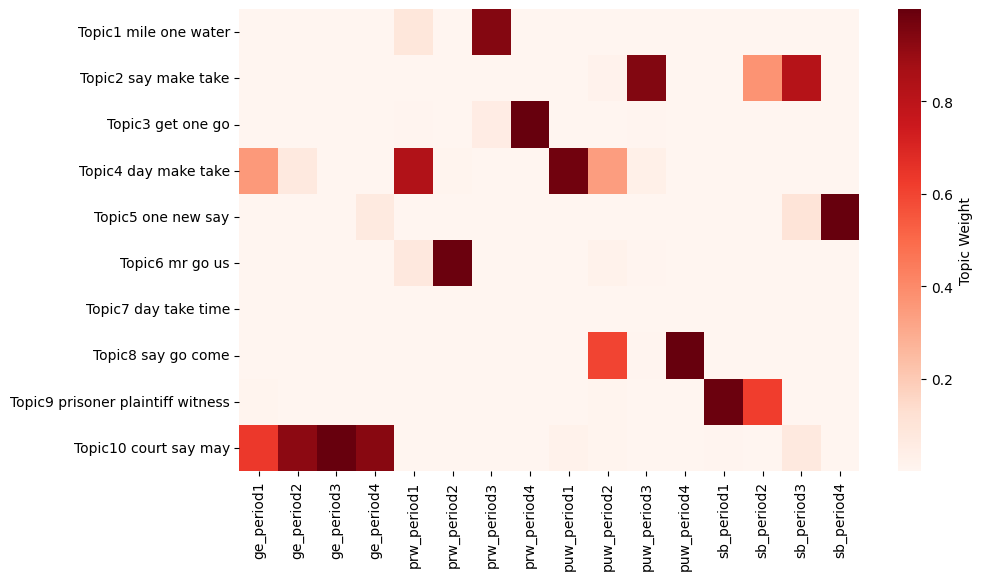

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.figure(figsize=(10, 6))  # Adjust the width and height
sns.heatmap(topics_transpose, 
            cmap='Reds',  # 'Reds' colormap corresponds to the red color scheme
            cbar_kws={'label': 'Topic Weight'},  # Color bar label
            linewidths=0,  # No lines between cells
            xticklabels=True,  # Show column labels
            yticklabels=True,  # Show row labels
            square=False,  # To avoid forcing the aspect ratio to be square
            cbar=True)  # Display color bar

# Rotate column labels
plt.xticks(rotation=90)

# Show the plot
plt.show()